In [1]:
from __future__ import annotations

from uuid import uuid4
from dataclasses import dataclass
from typing import Dict, List, Optional
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
n_agents        = [100, 300]         # Uniform range of agents per country
n_firms         = [10, 20]           # Uniform range of firms per country
n_countries     = 5                  # Number of countries

agent_wealth    = 0.0                # Initial CASH BUFFER only (leftover cash). Set 0 for clean stock-flow.
firm_wealth     = 1_000_000.0        # Initial wealth of firms
shares_out      = 1000               # Shares outstanding per firm

firm_dividend_share = 0.035          # Share of firm profit paid as dividends
house_price0    = 300_000.0          # Initial house price (each household owns one house)

riskfree        = 0.03               # Risk-free rate (constant)
inflation_rate  = 0.02               # Inflation rate (constant)

wage0           = 20_000.0           # Initial nominal wage (annual)
index_wage_to_inflation = True       # If True: wage grows with inflation each year

mps             = 0.08               # Marginal propensity to SAVE out of wage (NOT consume)

years           = 100                # Years to simulate


In [3]:
def crra_utility(wealth: float, gamma: float) -> float:
    """
    CRRA utility:
      u(W) = W^(1-gamma)/(1-gamma) for gamma != 1
      u(W) = log(W) for gamma == 1
    """
    w = max(float(wealth), 1e-12)
    if abs(gamma - 1.0) < 1e-12:
        return float(np.log(w))
    return float((w ** (1.0 - gamma)) / (1.0 - gamma))


def expected_crra_after_return(
    wealth: float,
    invest_amount: float,
    mean_return: float,
    std_return: float,
    gamma: float,
    n_mc: int = 20,
    rng: Optional[np.random.Generator] = None,
) -> float:
    """
    MVP expected utility for investing 'invest_amount' into one risky asset for one period.

    Assumptions:
      - one-period simple return r ~ Normal(mean_return, std_return)
      - wealth evolves as: W' = (wealth - invest_amount) + invest_amount * (1 + r)
      - small MC for E[u(W')]

    Note: returns clipped at -99% to prevent negative wealth blowups in MVP.
    """
    if rng is None:
        rng = np.random.default_rng()

    W = float(wealth)
    A = max(float(invest_amount), 0.0)
    A = min(A, W)

    r = rng.normal(loc=float(mean_return), scale=max(float(std_return), 1e-12), size=int(n_mc))
    r = np.clip(r, -0.99, None)

    W_next = (W - A) + A * (1.0 + r)
    utils = [crra_utility(w, gamma) for w in W_next]
    return float(np.mean(utils))

In [4]:
@dataclass(frozen=True)
class Trade:
    trade_id: str
    t: int
    firm_id: str
    buyer_id: str
    seller_id: str
    shares: int
    price: float
    notional: float


In [5]:
class Agent:
    def __init__(self, wealth: float, property_value: float = 0.0):
        self.wealth = float(wealth)                 # CASH BUFFER (leftover cash carried forward)
        self.property_value = float(property_value) # house value (one house)
        self.holdings: Dict[str, int] = {}          # firm_id -> shares (mirror for convenience)
        self.uuid = str(uuid4())

        self.last_wage = 0.0                        # wage flow for the current year (not part of wealth by default)

    def add_to_wealth(self, amount: float) -> None:
        self.wealth += float(amount)

    def deduct_from_wealth(self, amount: float) -> None:
        amount = float(amount)
        if amount > self.wealth + 1e-12:
            raise ValueError("Insufficient cash wealth.")
        self.wealth -= amount

    def get_total_wealth(self, prices_by_firm_id: Dict[str, float]) -> float:
        equity_value = sum(
            int(sh) * float(prices_by_firm_id[fid])
            for fid, sh in self.holdings.items()
            if sh != 0
        )
        return float(self.wealth + equity_value + self.property_value)


In [6]:
class Firm:
    def __init__(self, wealth: float, equity_premium: float, shares_outstanding: int = 1000):
        self.wealth = float(wealth)
        self.equity_premium = float(equity_premium)
        self.shares_outstanding = int(shares_outstanding)
        if self.shares_outstanding <= 0:
            raise ValueError("shares_outstanding must be positive.")

        self.uuid = str(uuid4())
        self.share_price = float(self.wealth / self.shares_outstanding)  # mid price

        # Source of truth: agent_id -> shares
        self.ownership: Dict[str, int] = {}

    def required_return(self, rf: float) -> float:
        return float(rf + self.equity_premium)

    def shares_of(self, agent_id: str) -> int:
        return int(self.ownership.get(agent_id, 0))

    def set_shares(self, agent_id: str, shares: int) -> None:
        shares = int(shares)
        if shares < 0:
            raise ValueError("shares must be non-negative.")
        self.ownership[agent_id] = shares

    def transfer_shares(self, seller_id: str, buyer_id: str, shares: int) -> None:
        shares = int(shares)
        if shares <= 0:
            raise ValueError("shares must be positive.")
        if self.shares_of(seller_id) < shares:
            raise ValueError("Seller has insufficient shares.")

        self.ownership[seller_id] = self.shares_of(seller_id) - shares
        self.ownership[buyer_id] = self.shares_of(buyer_id) + shares

    def total_owned_shares(self) -> int:
        return int(sum(self.ownership.values()))

    def update_share_price(self) -> None:
        self.share_price = float(self.wealth / self.shares_outstanding)


In [ ]:
class Country:
    def __init__(
        self,
        n_agents: int,
        n_firms: int,
        agent_wealth: float,
        firm_wealth: float,
        shares_outstanding: int,
        house_price: float,
        wage0: float,
        index_wage_to_inflation: bool = True,
        seed: Optional[int] = None,
    ):
        self.rng = np.random.default_rng(seed)

        self.house_price = float(house_price)
        self.wage = float(wage0)
        self.index_wage_to_inflation = bool(index_wage_to_inflation)

        self.agents: List[Agent] = [
            Agent(wealth=agent_wealth, property_value=self.house_price) for _ in range(int(n_agents))
        ]
        # initialise wage flow for year 0
        for a in self.agents:
            a.last_wage = self.wage

        self.firms: List[Firm] = [
            Firm(
                wealth=firm_wealth,
                equity_premium=float(self.rng.uniform(0.02, 0.10)),
                shares_outstanding=shares_outstanding,
            )
            for _ in range(int(n_firms))
        ]

        self.t: int = 0
        self.trades: List[Trade] = []

        self._initialise_equal_ownership()

    # -------- helpers --------

    def get_firm_prices(self) -> Dict[str, float]:
        return {f.uuid: float(f.share_price) for f in self.firms}

    def _agent_by_id(self, agent_id: str) -> Agent:
        for a in self.agents:
            if a.uuid == agent_id:
                return a
        raise KeyError("Unknown agent_id")

    def _firm_by_id(self, firm_id: str) -> Firm:
        for f in self.firms:
            if f.uuid == firm_id:
                return f
        raise KeyError("Unknown firm_id")

    # -------- initial ownership --------

    def _initialise_equal_ownership(self) -> None:
        n = len(self.agents)
        for firm in self.firms:
            base = firm.shares_outstanding // n
            rem = firm.shares_outstanding % n

            for i, agent in enumerate(self.agents):
                sh = base + (1 if i < rem else 0)
                firm.set_shares(agent.uuid, sh)
                agent.holdings[firm.uuid] = sh  # mirror

            if firm.total_owned_shares() != firm.shares_outstanding:
                raise RuntimeError("Initial share conservation failed.")

    # -------- core trading --------

    def _find_seller(self, firm: Firm, shares: int, exclude_id: str) -> Optional[str]:
        shares = int(shares)
        candidates = [
            a.uuid for a in self.agents
            if a.uuid != exclude_id and firm.shares_of(a.uuid) >= shares
        ]
        if not candidates:
            return None
        return candidates[int(self.rng.integers(0, len(candidates)))]

    def trade(self, firm_id: str, buyer_id: str, seller_id: str, shares: int) -> Trade:
        firm = self._firm_by_id(firm_id)
        buyer = self._agent_by_id(buyer_id)
        seller = self._agent_by_id(seller_id)

        shares = int(shares)
        if shares <= 0:
            raise ValueError("shares must be positive.")

        price = float(firm.share_price)  # mid
        notional = price * shares

        if buyer.wealth + 1e-12 < notional:
            raise ValueError("Buyer has insufficient cash buffer.")
        if firm.shares_of(seller_id) < shares:
            raise ValueError("Seller has insufficient shares.")

        # cash leg (cash buffer only)
        buyer.deduct_from_wealth(notional)
        seller.add_to_wealth(notional)

        # share leg
        firm.transfer_shares(seller_id=seller_id, buyer_id=buyer_id, shares=shares)

        # mirror update
        buyer.holdings[firm_id] = firm.shares_of(buyer_id)
        seller.holdings[firm_id] = firm.shares_of(seller_id)

        if firm.total_owned_shares() != firm.shares_outstanding:
            raise RuntimeError("Share conservation violated.")

        tr = Trade(
            trade_id=str(uuid4()),
            t=self.t,
            firm_id=firm_id,
            buyer_id=buyer_id,
            seller_id=seller_id,
            shares=shares,
            price=price,
            notional=notional,
        )
        self.trades.append(tr)
        return tr

    # =========================
    # Step 1: households invest out of (cash buffer + mps*wage)
    # =========================

    def step1_households_choose_and_trade(
        self,
        rf: float,
        gamma: float,
        mps: float,
        return_vol_scale: float = 0.10,
        n_mc_util: int = 20,
        temperature: float = 1.0,
    ) -> None:
        """
        Step 1:

        Each year, for each household:
          1) Add savings flow from wage into cash buffer:
                cash_buffer += mps * wage
          2) Choose a domestic firm based on expected CRRA utility of going (nearly) all-in.
          3) Attempt to convert cash buffer into shares at mid price by buying from other households.
          4) Any uninvested remainder stays in cash buffer for next year.

        Critical assumption (MVP):
          - No explicit consumption model yet.
          - Cash not invested remains as a risk-free cash buffer (does not earn rf here).
        """
        agents = list(self.agents)
        self.rng.shuffle(agents)

        for agent in agents:
            # 1) Savings flow: add mps*wage to cash buffer
            save_amount = float(mps) * float(agent.last_wage)
            if save_amount > 0:
                agent.add_to_wealth(save_amount)

            # If still no cash, skip
            if agent.wealth <= 0:
                continue

            # 2) Evaluate domestic firms using expected CRRA utility of investing (almost) all buffer
            utils = []
            firm_ids = []

            wealth_now = float(agent.wealth)
            invest_amount = wealth_now  # MVP: invest as much as possible (integer shares will leave remainder)

            for firm in self.firms:
                mu = firm.required_return(rf)
                sigma = return_vol_scale * abs(mu)

                eu = expected_crra_after_return(
                    wealth=wealth_now,
                    invest_amount=invest_amount,
                    mean_return=mu,
                    std_return=sigma,
                    gamma=gamma,
                    n_mc=n_mc_util,
                    rng=self.rng,
                )
                utils.append(eu)
                firm_ids.append(firm.uuid)

            # 3) Softmax choice
            u = np.array(utils, dtype=float)
            u = (u - np.max(u)) / max(float(temperature), 1e-12)
            p = np.exp(u)
            p = p / np.sum(p)

            chosen_firm_id = str(self.rng.choice(firm_ids, p=p))
            chosen_firm = self._firm_by_id(chosen_firm_id)

            # 4) Buy as many shares as possible at mid
            price = float(chosen_firm.share_price)
            shares_to_buy = int(agent.wealth // price)
            if shares_to_buy <= 0:
                continue

            seller_id = self._find_seller(chosen_firm, shares_to_buy, exclude_id=agent.uuid)
            if seller_id is None:
                continue

            # Execute trade; leftover cash remains in agent.wealth automatically
            try:
                self.trade(
                    firm_id=chosen_firm_id,
                    buyer_id=agent.uuid,
                    seller_id=seller_id,
                    shares=shares_to_buy
                )
            except ValueError:
                continue

    # =========================
    # Step 2: update macro prices + firms + dividends + wage/home for NEXT year
    # =========================

    def step2_update_prices_wages_profits(
        self,
        rf: float,
        inflation: float,
        dividend_share: float,
    ) -> None:
        """
        Step 2 (UPDATED):

        - Update house price with inflation (each household's property_value follows).
        - Update wage for next year (optionally indexed to inflation).
        - Firms generate profit based on required return; pay dividends; retain rest.
        - Share price updates from firm wealth (mid).

        Note: wage is stored as agent.last_wage (flow) for next Step 1.
        """
        # 1) Update nominal house price
        self.house_price *= (1.0 + float(inflation))
        for a in self.agents:
            a.property_value = self.house_price

        # 2) Update nominal wage (optional inflation index)
        if self.index_wage_to_inflation:
            self.wage *= (1.0 + float(inflation))

        for a in self.agents:
            a.last_wage = self.wage

        # 3) Firm profit -> dividends + retained -> update share price
        for firm in self.firms:
            profit = firm.wealth * firm.required_return(rf)

            dividends_total = profit * float(dividend_share)
            dps = dividends_total / firm.shares_outstanding

            # pay dividends (cash buffer increases)
            for a in self.agents:
                sh = firm.shares_of(a.uuid)
                if sh > 0:
                    a.add_to_wealth(dps * sh)

            # retained earnings raise firm wealth, then price updates
            retained = profit * (1.0 - float(dividend_share))
            firm.wealth += retained
            firm.update_share_price()

        self.t += 1

In [8]:
def run_simulation(
    n_countries: int,
    years: int,
    n_agents_range: tuple[int, int],
    n_firms_range: tuple[int, int],
    agent_wealth: float,
    firm_wealth: float,
    shares_outstanding: int,
    house_price: float,
    rf: float,
    inflation: float,
    wage0: float,
    index_wage_to_inflation: bool,
    dividend_share: float,
    gamma: float,
    mps: float,
    seed: int = 123,
) -> List[dict]:
    rng = np.random.default_rng(seed)

    countries = [
        Country(
            n_agents=int(rng.integers(n_agents_range[0], n_agents_range[1] + 1)),
            n_firms=int(rng.integers(n_firms_range[0], n_firms_range[1] + 1)),
            agent_wealth=agent_wealth,
            firm_wealth=firm_wealth,
            shares_outstanding=shares_outstanding,
            house_price=house_price,
            wage0=wage0,
            index_wage_to_inflation=index_wage_to_inflation,
            seed=int(rng.integers(0, 1_000_000_000)),
        )
        for _ in range(int(n_countries))
    ]

    sim_list: List[dict] = []

    for Y in tqdm(range(int(years)), total=years, desc="Simulating years"):
        for ci, C in enumerate(countries):
            # Step 1: households save mps*wage into cash buffer, then trade
            C.step1_households_choose_and_trade(
                rf=rf,
                gamma=gamma,
                mps=mps,
                return_vol_scale=0.10,
                n_mc_util=20,
                temperature=1.0,
            )

            # Step 2: update house price, wage for next year, firms + dividends + prices
            C.step2_update_prices_wages_profits(
                rf=rf,
                inflation=inflation,
                dividend_share=dividend_share,
            )

            prices = C.get_firm_prices()
            total_wealth = float(np.sum([a.get_total_wealth(prices) for a in C.agents]))
            avg_wealth = total_wealth / max(len(C.agents), 1)
            avg_price = float(np.mean(list(prices.values()))) if prices else float("nan")

            sim_list.append(
                dict(
                    year=Y,
                    country=ci,
                    n_agents=len(C.agents),
                    n_firms=len(C.firms),
                    avg_agent_total_wealth=avg_wealth,
                    avg_stock_price=avg_price,
                    house_price=C.house_price,
                    wage=C.wage,
                    n_trades=len(C.trades),
                )
            )

    return sim_list


In [12]:
sim = run_simulation(
    n_countries=n_countries,
    years=300,
    n_agents_range=(n_agents[0], n_agents[1]),
    n_firms_range=(n_firms[0], n_firms[1]),
    agent_wealth=agent_wealth,
    firm_wealth=firm_wealth,
    shares_outstanding=shares_out,
    house_price=house_price0,
    rf=riskfree,
    inflation=inflation_rate,
    wage0=wage0,
    index_wage_to_inflation=index_wage_to_inflation,
    dividend_share=np.random.uniform(0.02, 0.15),
    gamma=3.0,
    mps=np.random.uniform(0.02, 0.05),
    seed=42,
)

sim[:5]

Simulating years: 100%|██████████| 300/300 [03:27<00:00,  1.44it/s]


[{'year': 0,
  'country': 0,
  'n_agents': 117,
  'n_firms': 18,
  'avg_agent_total_wealth': 474447.72186184075,
  'avg_stock_price': 1079.5076198874594,
  'house_price': 306000.0,
  'wage': 20400.0,
  'n_trades': 0},
 {'year': 0,
  'country': 1,
  'n_agents': 188,
  'n_firms': 14,
  'avg_agent_total_wealth': 387912.9522344023,
  'avg_stock_price': 1079.675108027254,
  'house_price': 306000.0,
  'wage': 20400.0,
  'n_trades': 0},
 {'year': 0,
  'country': 2,
  'n_agents': 117,
  'n_firms': 17,
  'avg_agent_total_wealth': 464136.9811732946,
  'avg_stock_price': 1073.5012035114778,
  'house_price': 306000.0,
  'wage': 20400.0,
  'n_trades': 0},
 {'year': 0,
  'country': 3,
  'n_agents': 118,
  'n_firms': 15,
  'avg_agent_total_wealth': 444033.2319808357,
  'avg_stock_price': 1070.6976625471457,
  'house_price': 306000.0,
  'wage': 20400.0,
  'n_trades': 0},
 {'year': 0,
  'country': 4,
  'n_agents': 247,
  'n_firms': 18,
  'avg_agent_total_wealth': 385592.45287733455,
  'avg_stock_price'

In [13]:
sim_df = pd.DataFrame(sim)
sim_df.head()

,year,country,n_agents,n_firms,avg_agent_total_wealth,avg_stock_price,house_price,wage,n_trades
0,0,0,117,18,474447.721862,1079.507620,306000.0,20400.0,0
1,0,1,188,14,387912.952234,1079.675108,306000.0,20400.0,0
2,0,2,117,17,464136.981173,1073.501204,306000.0,20400.0,0
3,0,3,118,15,444033.231981,1070.697663,306000.0,20400.0,0
4,0,4,247,18,385592.452877,1072.638488,306000.0,20400.0,0


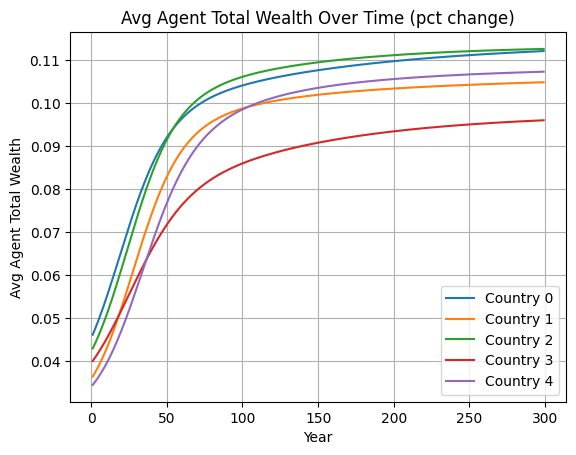

In [22]:
col = "avg_agent_total_wealth"
pct = True

plt.figure()
for C in range(n_countries):
    dfc = sim_df[sim_df["country"] == C]
    if pct:
        plt.plot(dfc["year"], dfc[col].pct_change(), label=f"Country {C}")
    else:
        plt.plot(dfc["year"], dfc[col], label=f"Country {C}")

plt.xlabel("Year")
plt.ylabel(col.replace("_", " ").title())
plt.title(f"{col.replace('_', ' ').title()} Over Time (pct change)" if pct else f"{col.replace('_', ' ').title()} Over Time")
plt.legend()
plt.grid()
if not pct:
    plt.yscale("log")
plt.show()

### Future improvements

- Add gini coefficient
- Add birthrate, and multiply by number of people in household so we can get per capita
 